# INNIO Fleet Analysis

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from pprint import (pprint as pp, pformat as pf)
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
import ipywidgets as widgets
import arrow

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)

### Filter Engines from installed fleet 

In [2]:
def sfun(x):
    return all([
            #("Forsa Hartmoor" in str(x['IB Site Name'])), 
            ("Landshut" in str(x['IB Site Name'])), 
            ("M4" in str(x['Engine ID'])), 
            (x['OperationalCondition'] != 'Decommissioned')
        ])

In [3]:
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
fleet.T

,0
Count_OpHour,18025.0
OperationalCondition,Running
startup_counter,1054.0
shutdown_counter,1062.0
id,117617
Engine Version,H01
Engine Type,624
Engine Series,6
Country,DE
Commissioning Date,2019-01-09


In [4]:
ddl = pd.DataFrame(fleet['serialNumber'] + ' - ' + fleet['IB Site Name'] + ' ' + fleet['Engine ID'])[0].to_list()
ddl = [(m, i) for i, m in enumerate(ddl)]
dl=widgets.Dropdown(options = ddl,value=0,description='Engine:',layout={'width':'max-content'},disabled=False)
display(dl)

Dropdown(description='Engine:', layout=Layout(width='max-content'), options=(('1320072 - BMW Landshut 4.10 M4'…

In [5]:
e=dmyplant2.Engine.from_fleet(mp,motor:=fleet.iloc[dl.value])
pd.DataFrame.from_dict(e.dash, orient='index').T

,Name,Engine ID,Design Number,Engine Type,Engine Version,P,P_nom,BMEP,serialNumber,id,Count_OpHour,val start,oph@start,oph parts,LOC
0,BMW Landshut 4.10 M4,M4,U781,624,H01,24,4500.0,24.5,1320072,117617,18180.0,2019-01-09,1384,16796.0,0.072


In [26]:
from dfsm import msgFSM
#fsm = msgFSM(e, skip_days=7) #funktioniert nicht
#fsm = msgFSM(e, p_from=motor['Commissioning Date'], p_to=arrow.now() )
fsm = msgFSM(e, p_from="2022-01-01", p_to=arrow.now(), frompickle=True)
#fsm = msgFSM(e)
fsm.run1(enforce=True) # run Finite State Machine
fsm.store()

FSM: 100%|████████████████████████| 5929/5929 [00:00<00:00, 11963.81 messages/s]


In [27]:
# Struktur zur Aufnahme mehrerer motoren
fsm_data = []
fsm_data.append({'engine':e, 'fsm':fsm})

In [28]:
res = fsm_data[0]
res['result'] = pd.DataFrame(fsm_data[0]['fsm']._starts)
fsm.summary(res)

,From,To,Days
Interval,01.01.2022,23.02.2022,53


,Starts,successful,%
???,24,23,95
OFF,5,2,40
MANUAL,23,6,26
AUTO,241,217,90
ALL,293,248,84


In [29]:
rmodes = ['???','OFF','MANUAL','AUTO']; mw = [] ; modes = []
for mm in rmodes:
    mw.append(widgets.Checkbox(value=False, description='Mode: ' + mm))
display(widgets.VBox(mw))

In [30]:
rsucc = [True,False]; sw = []; success=[]
for rs in rsucc:
    sw.append(widgets.Checkbox(value=False, description='Success: ' + str(rs)))
display(widgets.VBox(sw))

In [31]:
rdf = res['result']
modes = [rmodes[i] for i,v in enumerate(mw) if v.value]
modes = rmodes if not modes else modes
success = [rsucc[i] for i,v in enumerate(sw) if v.value]
success = rsucc if not success else success

rda = rdf[:].reset_index(drop='index')
rda['count_alarms'] = rda.apply(lambda x: len(x['alarms']), axis=1)
rda['count_warnings'] = rda.apply(lambda x: len(x['warnings']), axis=1)
rda = rda[((rdf['mode'].isin(modes)) & (rdf['success'].isin(success)))].reset_index(drop='index')
print(modes, success)

['???', 'OFF', 'MANUAL', 'AUTO'] [True, False]


In [32]:
# special filters can be added like ... 
#rda = rda[((rda['loadramp'] < 80.0) & (rda['startpreparation'] < 300.0))].reset_index(drop='index')

# rda = rda[((rda['count_warnings'] == 0) & (rda['count_alarms'] == 0))].reset_index(drop='index')
# display the filterd & selected data
rda[fsm.filters['filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,targetoperation,count_alarms,count_warnings
0,True,???,261.96,5.25,16.13,6.79,19.46,215.00,524.58,0 days 01:26:17,0,0
1,True,???,261.82,4.94,17.14,6.95,20.80,512.83,824.47,0 days 18:59:51,0,5
2,True,???,261.74,4.74,17.32,7.16,17.08,595.93,903.98,0 days 01:13:47,0,0
3,False,???,13.51,NaN,NaN,NaN,NaN,NaN,13.51,NaT,0,0
4,False,MANUAL,92.06,NaN,NaN,NaN,NaN,NaN,92.06,NaT,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
288,True,AUTO,261.74,4.54,14.13,6.56,17.08,138.89,442.95,0 days 00:15:22,0,0
289,True,AUTO,261.62,6.24,13.00,6.35,20.20,138.89,446.30,0 days 02:36:50,0,1
290,True,AUTO,261.84,4.44,14.61,6.37,27.53,138.89,453.68,0 days 00:17:39,0,0
291,True,AUTO,261.58,4.95,14.02,6.47,19.39,138.89,445.29,0 days 02:18:03,0,0


In [40]:
rda = fsm.run2(rda)
fsm.store()

FSM Run2: 100%|███████████████████████| 293/293 [00:00<00:00, 16305.74 starts/s]


In [41]:
rdb = rda[(rda['mode'] == 'AUTO') & rda['success'] & (rda['maxload'] > 4000.0)]
rdb[fsm.filters['run2filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

,index,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,count_alarms,count_warnings
5,5,True,AUTO,261.82,5.14,16.85,7.65,18.17,505.95,815.59,4506.67,0.20,0 days 00:16:13,0.0,3.0
6,6,True,AUTO,261.93,4.63,17.67,7.57,8.99,519.97,820.75,4493.00,0.19,0 days 20:21:38,0.0,3.0
7,7,True,AUTO,261.47,5.76,14.91,6.75,8.99,570.38,868.26,4502.00,0.18,0 days 01:34:51,0.0,0.0
8,8,True,AUTO,261.36,4.33,15.93,6.56,21.18,656.01,965.37,4503.00,0.15,8 days 10:42:51,0.0,30.0
9,9,True,AUTO,345.26,5.03,22.09,7.56,18.75,515.92,914.62,4499.00,0.19,2 days 10:35:57,0.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,46,True,AUTO,260.93,4.83,15.34,6.34,27.95,19856.83,20172.22,4494.00,0.01,4 days 04:44:37,0.0,6.0
282,47,True,AUTO,261.48,4.74,17.15,7.17,7.96,511.64,810.14,4437.00,0.19,1 days 23:23:20,0.0,25.0
287,52,True,AUTO,261.58,4.12,15.44,6.74,20.46,506.86,815.21,4500.00,0.20,0 days 17:04:42,0.0,21.0
291,56,True,AUTO,260.64,4.44,13.70,6.35,19.44,513.80,818.38,4505.00,0.19,0 days 02:47:49,0.0,3.0


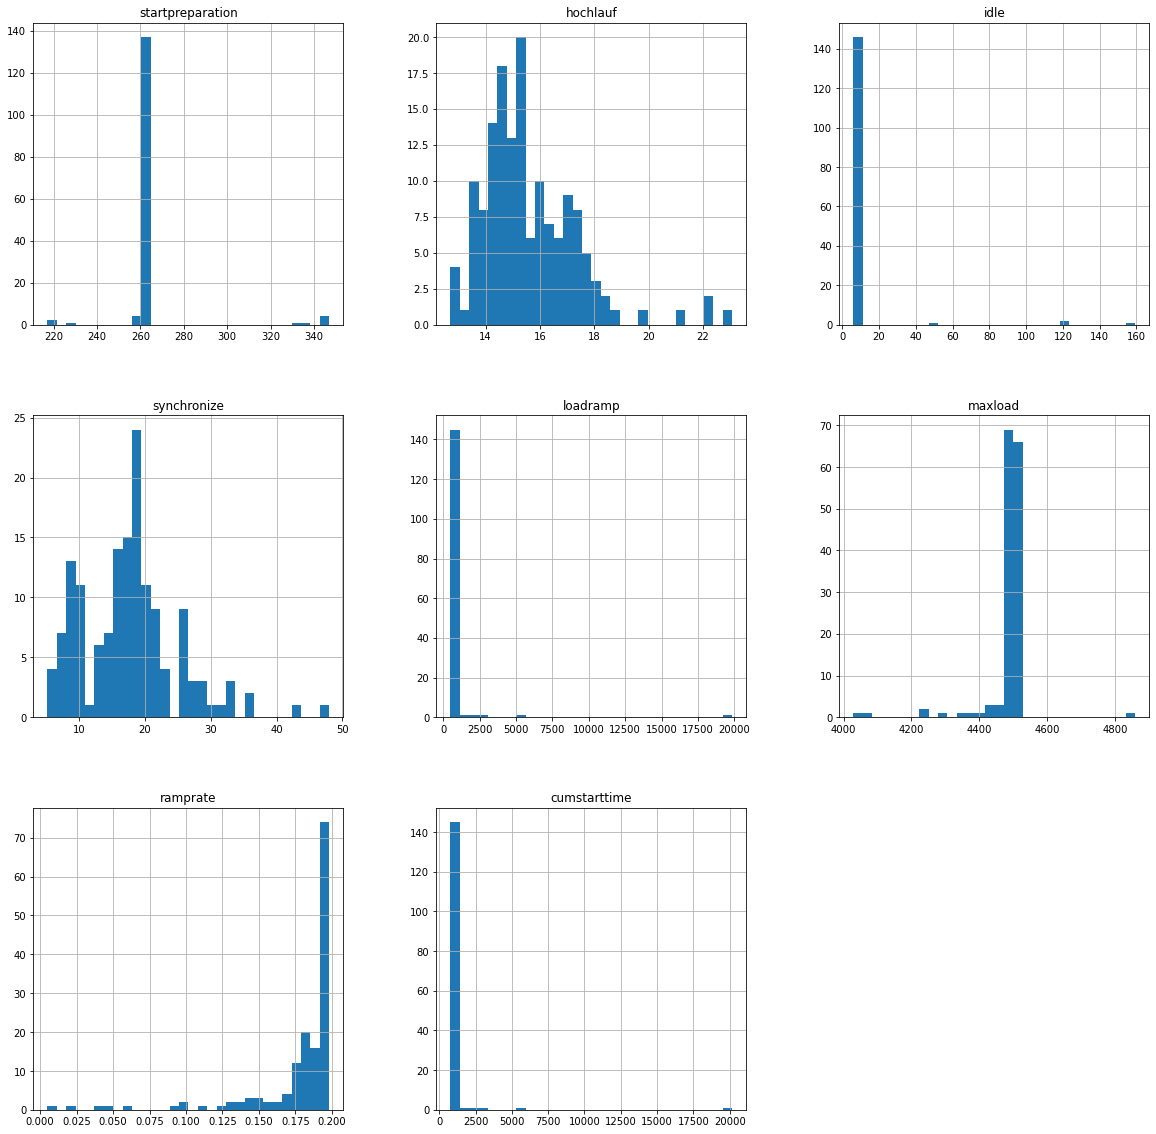

In [16]:
rdb[['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime']].hist(bins=30,figsize=(20,20));

In [20]:
rdb[['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime']].describe().round(2)

,startpreparation,hochlauf,idle,synchronize,loadramp,maxload,ramprate,cumstarttime
count,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00
mean,264.01,15.61,9.75,17.68,747.20,4485.72,0.18,1059.02
std,16.95,1.76,18.24,7.41,1636.12,71.97,0.03,1636.51
min,217.15,12.71,6.03,5.14,489.44,4029.00,0.01,772.76
25%,261.21,14.45,6.66,13.17,506.43,4493.00,0.18,813.61
50%,261.61,15.23,6.87,17.78,519.77,4498.96,0.19,830.17
75%,261.93,16.57,7.17,20.57,563.38,4502.75,0.20,886.39
max,347.01,23.08,159.32,48.02,19856.83,4859.34,0.20,20172.22


In [50]:
startversuch = rda.iloc[46];
von_dt=pd.to_datetime(startversuch['starttime']); von=int(von_dt.timestamp() - fsm._pre_period)
bis_dt=pd.to_datetime(startversuch['endtime']); bis=int(bis_dt.timestamp())

cycle = 1 #sec.
data = fsm.get_period_data(von, bis, cycletime=cycle)
ftitle = f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
print(f"von: {von_dt.strftime('%d.%m.%Y %H:%M:%S')} = {von} bis: {bis_dt} = {bis}")
data = fsm.get_cycle_data(startversuch, max_length=None, min_length=None, cycletime=1, silent=True)

SyntaxError: f-string: invalid syntax (602403705.py, line 8)

In [44]:
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000)},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500]}
]
dmyplant2.dbokeh_chart(data, dset, title=ftitle, figsize=(6,4))

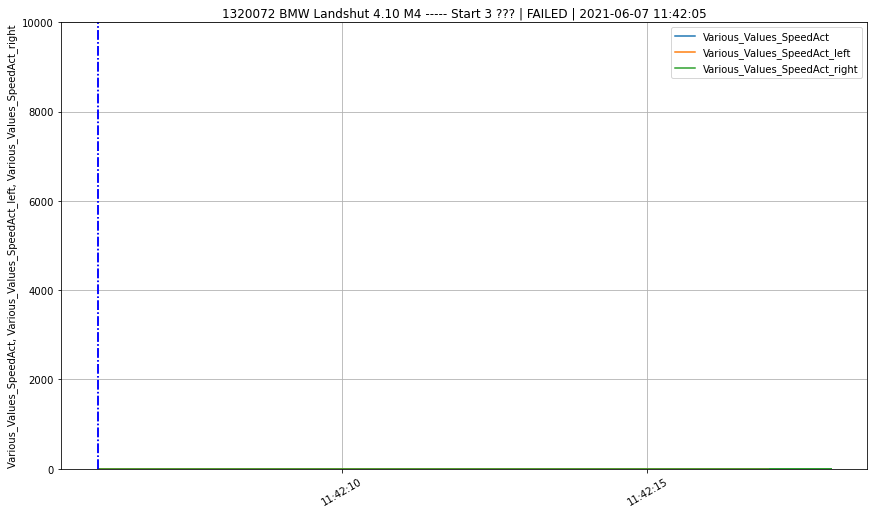

In [45]:
dset = [
    {'col':['Various_Values_SpeedAct','Various_Values_SpeedAct_left', 'Various_Values_SpeedAct_right'], 'ylim':(0,10000)}
]
pl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
pr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle="-.")
dmyplant2.add_lines(pr.loc, [], ax, color='blue', linestyle="-.")

In [ ]:
dset = [
    {'col':['Power_PowerAct','Power_PowerAct_left','Power_PowerAct_right'], 'ylim':(0,40000)}
]
pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)
dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle=":")
dmyplant2.add_lines(pr.loc, [], ax, color='purple', linestyle=":")

In [ ]:
dset = [
    {'col':['Power_PowerAct','Various_Values_SpeedAct'], '_ylim':(0,40000)},
    {'col':['Power_PowerAct_left','Power_PowerAct_right','Various_Values_SpeedAct_left', 'Various_Values_SpeedAct_right'], '_ylim':(0,40000)}
    ]

pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
sl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
sr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')
fig, ax, axes = dmyplant2.chart(data, dset, figsize=(14,8), title=ftitle)

sv_lines = [v for v in startversuch[fsm.filters['vertical_lines_times']] if v==v]
start = startversuch['starttime']; lines=list(np.cumsum(sv_lines))
dmyplant2.add_lines(start, lines, ax, color='red', linestyle="dotted")
dmyplant2.add_lines(sl.loc, [], ax, color='blue', linestyle="-.")
dmyplant2.add_lines(sr.loc, [], ax, color='purple', linestyle="-.")
dmyplant2.add_lines(pl.loc, [], ax, color='green', linestyle="-.")
dmyplant2.add_lines(pr.loc, [], ax, color='orange', linestyle="-.")

summary = pd.DataFrame(startversuch[fsm.filters['filter_times']], dtype=np.float64).round(2).T
dmyplant2.add_table(summary, ax, loc='upper left')

plt.show()

In [ ]:
dset = [
    {'col':['Power_PowerAct','Various_Values_SpeedAct'], '_ylim':(0,10000)}
]
for ii,startversuch in rda.iterrows():
        if ii < 0:
                continue
        if ii > 10:
                break
        data = fsm.get_cycle_data(startversuch, max_length=None, min_length=None, cycletime=1)

        pl = fsm.detect_edge(data, 'Power_PowerAct', kind='left')
        pr = fsm.detect_edge(data, 'Power_PowerAct', kind='right')
        sl = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='left')
        sr = fsm.detect_edge(data, 'Various_Values_SpeedAct', kind='right')

        ftitle = f"{fsm._e} ----- Start {ii} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
        #ax, ax2, idf = dmyplant2._plot(data, style='.-', figsize=(18,10), title=ftitle);
        fig, ax, axes = dmyplant2.chart(data, dset, figsize=(12,8), title=ftitle)

        ml = (data.iloc[-1]['time'] - data.iloc[0]['time']) // 1000
        sv_lines = [v for v in startversuch[fsm.filters['vertical_lines_times']]]

        start = startversuch['starttime'];
        
        nsv_lines = [v for v in sv_lines if ((v==v) and (v <= ml)) ]
        lines=list(np.cumsum(nsv_lines))
        dmyplant2.add_lines(start, lines, ax, color='red', linestyle="--")

        dmyplant2.add_lines(sl.loc, [], ax, color='green', linestyle="-")
        dmyplant2.add_lines(sr.loc, [], ax, color='green', linestyle="-.")
        dmyplant2.add_lines(pl.loc, [], ax, color='blue', linestyle="-")
        dmyplant2.add_lines(pr.loc, [], ax, color='blue', linestyle="-.")

        svdf = pd.DataFrame(sv_lines, index=fsm.filters['vertical_lines_times'], columns=['FSM']).fillna(0)
        svdf['RUN2'] = svdf['FSM']
        #if svdf.at['hochlauf','FSM'] > 0.0:
        #        svdf.at['hochlauf','RUN2'] = sl.loc.timestamp() - start.timestamp() - np.cumsum(svdf['RUN2'])['starter']
        #        svdf.at['idle','RUN2'] = svdf.at['idle','FSM'] - (svdf.at['hochlauf','RUN2'] - svdf.at['hochlauf','FSM'])
        if svdf.at['loadramp','FSM'] > 0.0:
                svdf.at['loadramp','RUN2'] = pl.loc.timestamp() - start.timestamp() - np.cumsum(svdf['RUN2'])['synchronize']
        svdf = pd.concat([
                svdf, 
                pd.DataFrame.from_dict(
                        {       'maxload':['-',pl.val],
                                'ramp':['-',(pl.val / fsm._e['Power_PowerNominal']) * 100 / svdf.at['loadramp','RUN2']],
                                'cumstarttime':[np.cumsum(svdf['FSM'])['loadramp'], np.cumsum(svdf['RUN2'])['loadramp']]
                        }, 
                        columns=['FSM','RUN2'],
                        orient='index')]
                )


        #summary = pd.DataFrame(startversuch[fsm.filter_times], dtype=np.float64).round(2).T
        summary = pd.DataFrame(svdf['FSM']).round(1).T
        dmyplant2.add_table(summary, ax, loc='upper left')
        #display(HTML(summary.to_html(escape=False)))
        display(HTML(svdf.round(2).T.to_html(escape=False)))


        for i, al in enumerate(startversuch['alarms']):
                print(f"{al['state']:16} {fsm.msgtxt(al['msg'],i)}")

        for i, w in enumerate(startversuch['warnings']):
                print(f"{w['state']:16} {fsm.msgtxt(w['msg'],i)}")
        
        #fsm.plot_cycle(startversuch, max_length=600, ylim=(0,2500), cycletime=1, style='.-', figsize=(10,6), 
        #    title=f"{fsm._e} ----- Start {startversuch.name} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}");
        plt.show();

In [ ]:
rda.describe().round(1).T

In [ ]:
longer_than_300s = rda[fsm.filters['filter_period'] + fsm.filters['filter_content']][rda['cumstarttime'] > 300.0]
longer_than_300s[fsm.filters['filter_content']].round(2)

In [ ]:
longer_than_300s.describe().round(2).T

In [ ]:
load_ramp_less_than_100s = rdb[fsm.filters['filter_period'] + fsm.filters['run2filter_content']][(rdb['loadramp'] < 100.0) & (rdb['maxload'] > 4000.0)]
lfsm = load_ramp_less_than_100s[['starttime']+fsm.filters['run2filter_content']].reset_index(drop='index').round(2)
lfsm

In [ ]:
rdc = rdb[rdb.starttime > '2022-01-01']
dset = [
    {'col':['ramprate'],'ylim':(-1,3)},
    {'col':['cumstarttime'],'ylim':(0,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(0,400)},
    {'col':['startpreparation'],'ylim':(-100,200)},
    {'col':['hochlauf'],'ylim':(0,100), 'color':'black'},
    {'col':['maxload'],'ylim':(500,5500) }
]
ftitle = f"{fsm._e}"
dmyplant2.dbokeh_chart(rdc, dset, x='starttime', figsize=(16,10) ,title=ftitle);

In [ ]:
dset = [
    {'col':['ramprate'],'ylim':(0,1.5)},
    {'col':['synchronize'],'ylim':(0,200)},
    {'col':['cumstarttime'],'ylim':(0,400)},
    {'col':['maxload'],'ylim':(0,5000) }
]
dmyplant2.chart(rdb, dset, x='starttime', figsize=(12,8), title=ftitle);

In [ ]:
rda.reset_index(drop='index').iloc[10];

In [ ]:
for i, r in load_ramp_less_than_100s.reset_index(drop='index').iterrows():
    fsm.plot_cycle(r, max_length=8*60, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {r['starttime'].round('S')}")
    plt.show()


In [ ]:
load_ramp_less_than_100s.describe().round(2).T

In [ ]:
rda[['startpreparation','starter','hochlauf','idle','synchronize','cumstarttime','loadramp','targetoperation']].hist(figsize = (20,12), bins=80, layout=(3,3));
#rda.hist(figsize = (20,12), bins=100, layout=(4,2));

In [ ]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 1
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            print(_txt)
            if ct2 >= mini and ct2 <= maxi:
                fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                plt.show()
            ct2 += 1

print(f"""
***********************************
** {ct:3} nicht erfolgreiche Starts **
***********************************
""")

In [ ]:
al = pd.DataFrame(fsm._pareto(nalarms))
fig = plt.figure();
color = 'purple'

if not al.empty:
    al['msg'] = al['msg'] + ' (' + al['name'] + ')'
    al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title='Alarms in not successful Starts');
    plt.plot();

In [ ]:
phases = [['startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation'],'startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation']
fig = plt.figure();
color = 'red'

for phase in phases:
    al = fsm.alarms_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
fig = plt.figure();
color = 'orange'

for phase in phases:
    al = fsm.warnings_pareto(phase)[:30]
    if not al.empty:
        al['msg'] = al['msg'] + ' (' + al['name'] + ')'
        al.set_index('msg').sort_values(by = "anz",ascending=True).plot.barh(y=['anz'],figsize=(16,len(al) / 3.8), color=[color], position = 1.0, grid=True, title=' | '.join(phase) if type(phase) == list else phase);
        plt.plot();


In [ ]:
mfn = e._fname + '_messages.txt'
fsm.save_messages(mfn)
print(mfn)

In [ ]:
any(fsm._messages['name'] == '9047')

In [ ]:
#fsm.store()